<center><b>DATA 620 - Final Project</b></center>

<center><b>Ohannes (Hovig) Ohannessian</b></center>

<p>The objective of this project is to conduct a study on a Twitter account, setup the needed API calls and view an observation of followers of that account. The analysis will be derived to understand different topics about cloud companies that are currently talking about in the tweets. We will specifically mention IBM Cloud Platform to study it and visualize its outputs. [There's a short proposal written about this project if you'd like to read it](https://raw.githubusercontent.com/hovig/MSDS_CUNY/master/DATA620/final_project_proposal_notebook/data620_final_project_proposal.txt).</p>

In [154]:
import twitter
import json
import sys
import re
from collections import Counter
import nltk
import networkx as nx
import matplotlib.pyplot as plt
import oauth2 as oauth
import numpy as np
import pandas as pd
import seaborn as sns
import csv
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn import cross_validation
sns.set(color_codes=True)
%matplotlib inline

<b>Libraries and credentials</b>
* Load Python libraries for the project
* Next, assign token keys, credentials and Twitter username
* `Credentials, will be excluded out for security reasons but it can be replaced with yours and be used`

In [155]:
CONSUMER_KEY = 'dnl48nYUalAOjqZfH69KsKF45'
CONSUMER_SECRET = 'XO9jTJgLN4tTHjX5e8W5Sw0EwUamHy5DMQ5rzEzo5teSkHhVNx'
OAUTH_TOKEN = '3310693076-8nrrIxYQ7HyqS4nyiiDDHPaWPUTfh3ECSxDqcHq'
OAUTH_TOKEN_SECRET = 'n3Ewa1eGUYIMgGLu7cBFYYqqMCa8mPPvozHu8MhloYk5N'

<b>URLs and authentication</b>
- URLs (Twitter, user followers, etc.)
- Authentication
- Request call status should be 200

In [156]:
auth = twitter.oauth.OAuth(OAUTH_TOKEN, OAUTH_TOKEN_SECRET,CONSUMER_KEY, CONSUMER_SECRET)

twitter_api = twitter.Twitter(domain='api.twitter.com', 
                              api_version='1.1', auth=auth)

consumer = oauth.Consumer(key=CONSUMER_KEY, secret=CONSUMER_SECRET)
token = oauth.Token(key=OAUTH_TOKEN, secret=OAUTH_TOKEN_SECRET)
client = oauth.Client(consumer, token)

FOLLOWERS_URL = 'https://api.twitter.com/1.1/followers/list.json'
screen_name = 'hovig613'

url = FOLLOWERS_URL + '?screen_name=' + screen_name
header, response = client.request(url, method='GET')
    
print 'status:', header['status'] 
print response[:200] 

status: 200
{"users":[{"id":991046317760765952,"id_str":"991046317760765952","name":"Mimo","screen_name":"Mimo97110905","location":"","description":"\u0644\u0627 \u0628\u0646\u062a \u0648\u0632\u064a\u0631 \u0648


<b>Twitter user's followers</b>
- Iterate over twitter followers
- Convert JSON string into a dictionary object
- Get all `screen_name`'s followers, capture, store in list
- Run to check next_cursor and followers

In [157]:
data = json.loads(response) 
followers = [u['screen_name'] for u in data['users']]

for i in followers:
    followers[followers.index(i)] = unicodedata.normalize('NFKD', i).encode('ascii','ignore')

print 'Count of: ', len(followers), 'followers so far:', followers

Count of:  5 followers so far: ['Mimo97110905', 'dinesh_Sail', 'TechGripes', 'VickyLuzBello', 'ojas']


<b>Graph display of followers</b>
* Add edges if there's any relationship among the followers

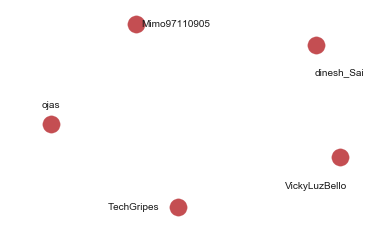

In [158]:
G = nx.DiGraph(name="hovig613's Twitter Followers")  

G.add_nodes_from(followers)
pos_labels = {}
pos = nx.fruchterman_reingold_layout(G,k=.12);
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y)
nx.draw_networkx_labels(G, pos_labels, font_size=10) 

nx.draw(G)
plt.show()

<b>Understanding relationships between followers</b>
- Check if neighbor is applicable to G
- Use predecessors function to identify linked nodes in G:

In [159]:
parser = csv.reader(followers)

for fields in parser:
  for i,f in enumerate(fields):
    if not G.neighbors(f):
        print f," has no relationship."
    if not G.predecessors(f):
        print f," has no predecessor."

Mimo97110905  has no relationship.
Mimo97110905  has no predecessor.
dinesh_Sail  has no relationship.
dinesh_Sail  has no predecessor.
TechGripes  has no relationship.
TechGripes  has no predecessor.
VickyLuzBello  has no relationship.
VickyLuzBello  has no predecessor.
ojas  has no relationship.
ojas  has no predecessor.


<b>Check for new followers</b>
- use cursor to get next 20 results
- convert JSON to dictionary object

In [160]:
url = FOLLOWERS_URL + '?screen_name=' + screen_name + '&cursor=' + str(next_cursor)
header, response = client.request(url, method='GET')

data = json.loads(response) 
next_cursor = data['next_cursor']
new_followers = [u['screen_name'] for u in data['users']]
followers.extend(new_followers)

print len(new_followers), 'new followers:', new_followers
print "Request call status: ", header['status'], "\nCallback response json object: ", response

0 new followers: []
Request call status:  200 
Callback response json object:  {"users":[],"next_cursor":0,"next_cursor_str":"0","previous_cursor":0,"previous_cursor_str":"0"}


- Using the Cursor object which will get the first 100 tweets per user
- Check the targeted topic in the tweets

In [161]:
search_results = twitter_api.search.tweets(q="IBM Cloud Company", count=100)
statuses = search_results['statuses']

for _ in range(5): 
    try:
        next_results = search_results['search_metadata']['next_results']
    except KeyError, e: 
        break

    kwargs = dict([ kv.split('=') for kv in next_results[1:].split("&") ]) 
    search_results = twitter_api.search.tweets(**kwargs)
    statuses += search_results['statuses']
    
json_dumps = json.dumps(statuses[0:2], indent=1)

print json_dumps[:150]

[
 {
  "contributors": null, 
  "truncated": false, 
  "text": "RT @crypto_vert: #cashaa\u2019s parental company auxesis is using #IBM cloud computing


- <b>Store tweets in a list</b>

In [162]:
tweets = [status['text'] for status in statuses]
print tweets[0]

RT @crypto_vert: #cashaa’s parental company auxesis is using #IBM cloud computing to achieve next generation blockchain infrastructure #cas…


- <b>Distribution of summary lengths</b>

136.6875
70
144
11.3176783728


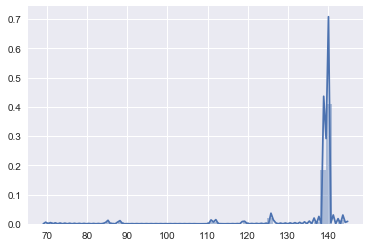

In [163]:
lengths = np.array([len(i) for i in tweets])
print(np.mean(lengths))
print(np.min(lengths))
print(np.max(lengths))
print(np.sqrt(np.var(lengths)))
sns.distplot(lengths)

- Study lengths and average words per tweet
- Print results 

In [164]:
words = []
for t in tweets:
    words += [ w for w in t.split() ]

length_total_words = len(words) 
length_unique_words = len(set(words)) 
avg_words_per_tweet = 1.0*sum([ len(t.split()) for t in tweets ])/len(tweets) 

print length_total_words
print length_unique_words
print avg_words_per_tweet

1948
400
20.2916666667


<b>Out of 100, check and print the:</b>
<ul>
<li>50 most frequent tokens </li>
<li>50 least frequent tokens</li>
</ul>

In [165]:
freq_distribution = nltk.FreqDist(words)
print freq_distribution.keys()[:50],"\n"
print freq_distribution.keys()[-50:] 

[u'all', u'https://t.co/aB0UopJRlr', u'several\u2026', u'Mutuel', u'Dat', u'to', u'https://t.co/OrWCO5eUWf', u'Logistics', u'https://t.co/ldtqphAzgv', u'https://t.co/mErEQj4HEE', u'companies', u'large', u't\u2026', u'11:45', u'Only', u'video', u'what', u'https://t.co/YoRVrUfdRu', u'showcase', u'+', u'#logistics,', u'revolutionize', u'Put', u'new', u'exchange', u'Multi-Cloud', u'https://t.co/DucYWF6c8U', u'(Netherlands),', u'Azure', u'.@IBM', u'publisher', u'#blockchain', u'Your', u'bank\u2019s', u'#AI', u'Or\u2026', u'Technology', u'company.', u'company,', u'followed', u'win', u'https://t.co/p88gocNHeI', u'1st', u'cloud', u'Europe', u'the\u2026', u'blockchain', u'by', u'Driven', u'6'] 

[u'was', u'war', u'https://t.co/kiAjK7QZi9', u'company\u2019s', u'Weath\u2026', u'#customers', u'services,', u'services.', u'with', u'utilizing', u'#Europe', u'25th', u'attached', u'https://t.co/XJxe6pVOS8', u'unveils', u"tomorrow's", u'Engineering', u'minutes', u'https://t.co/hxNWzKi02e', u'computing',

In [166]:
retweeted_patterns = re.compile(r"(RT|via)((?:\b\W*@\w+)+)", re.IGNORECASE)
our_tweets = ["RT @hovig613 - IBM Cloud", "IBM Watson Cloud (@hovig613)"]
for t in our_tweets:
    print retweeted_patterns.findall(t)

[('RT', ' @hovig613')]
[]


<b>Populate Graph with Nodes and Edges</b>
- Identify objects of interest
- Depict relationships between them
- Add multiple nodes at same time by passing list of items
- Define edges between nodes
- Set of relatoinships between nodes in graph
- Graph start and end points for the connection
- Add multiple edges at same time by adding list of tuples 

Name: Most Tweeted Cloud Companies
Type: DiGraph
Number of nodes: 61
Number of edges: 57
Average in degree:   0.9344
Average out degree:   0.9344


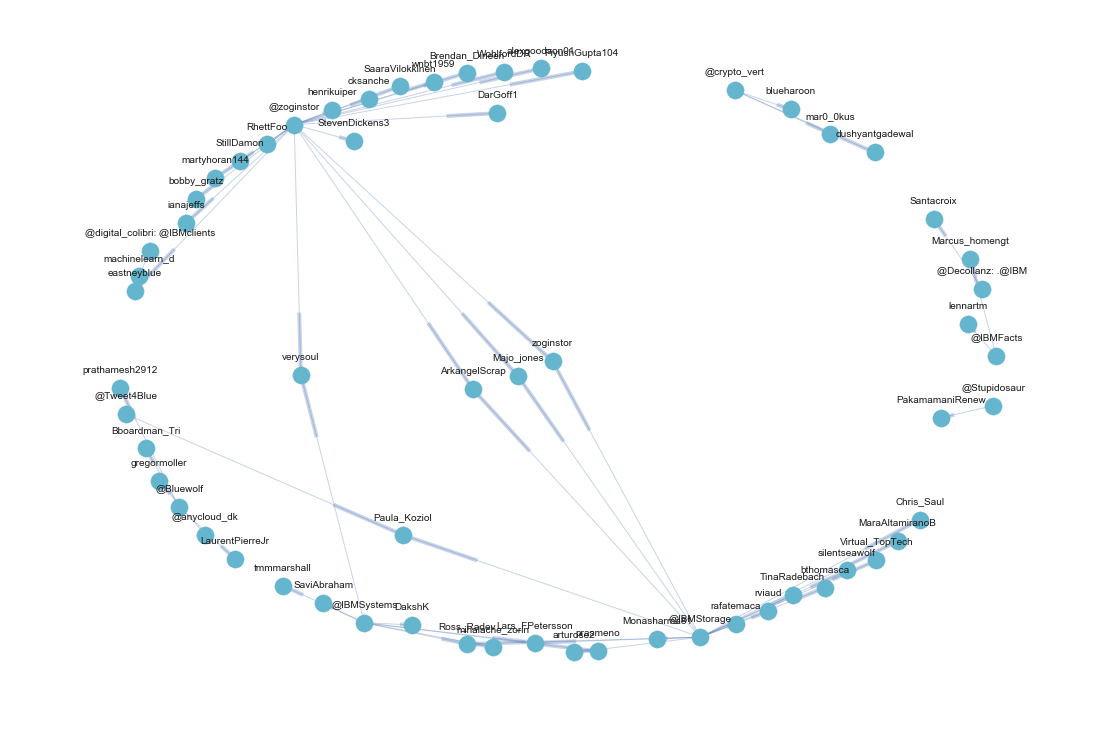

In [167]:
g = nx.DiGraph(name="Most Tweeted Cloud Companies")
pos_labels = {}

def get_retweeted_sources(tweet):
    retweeted_patterns = re.compile(r'(RT|via)((?:\b\W*@\w+)+)', re.IGNORECASE)
    return [ source.strip()
             for tuple in retweeted_patterns.findall(tweet)
                 for source in tuple if source not in ("RT", "via") ]

for status in statuses:
    retweeted_patterns = get_retweeted_sources(status['text'])
    if not retweeted_patterns: continue
    for i in retweeted_patterns:
        g.add_edge(i, status['user']['screen_name'], {'tweet_id' : status['id']})
            
print nx.info(g)

plt.figure(figsize=(19,13));
pos = nx.fruchterman_reingold_layout(g,k=.12);
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y+0.03)
nx.draw_networkx_edges(g,pos, edge_color='b',alpha=.3);
nx.draw_networkx_nodes(g,pos,node_color='c',node_size=300);
nx.draw_networkx_labels(g,pos_labels,font_size=10) 
plt.axis('off')
plt.show()

In [168]:
print "The number of nodes are: ",g.number_of_nodes(),"\nThe number of edges: ",g.number_of_edges()

The number of nodes are:  61 
The number of edges:  57


<b>The list of Networkx degree of g</b>

In [169]:
deg = nx.degree(g)
for i in deg:
    deg[i] = unicodedata.normalize('NFKD', i).encode('ascii','ignore')

print "The degree values are: ",[deg[x] for x in deg]

The degree values are:  ['WohlfordDR', 'lennartm', '@anycloud_dk', 'rafatemaca', 'ArkangelScrap', 'Santacroix', 'zoginstor', 'prathamesh2912', 'Marcus_homengt', 'PakamamaniRenew', 'LaurentPierreJr', 'Chris_Saul', 'Virtual_TopTech', 'SaaraVilokkinen', 'arturose2', 'eastneyblue', '@Tweet4Blue', 'Brendan_Dineen', '@IBMSystems', 'bobby_gratz', 'TinaRadebach', 'gregormoller', 'MaraAltamiranoB', 'cksanche', 'rviaud', 'machinelearn_d', 'StillDamon', '@IBMStorage', 'Monasharma81', 'Majo_jones', 'blueharoon', 'Lars_FPetersson', 'Paula_Koziol', 'bthomasca', 'verysoul', 'dushyantgadewal', 'tmmmarshall', 'ianajeffs', '@Bluewolf', '@digital_colibri: @IBMclients', 'martyhoran144', '@zoginstor', 'StevenDickens3', 'Bboardman_Tri', '@Decollanz: .@IBM', '@crypto_vert', '@Stupidosaur', 'RhettFoo', 'silentseawolf', 'henrikuiper', 'DarGoff1', 'alexgoodson01', 'PiyushGupta104', 'wnbt1959', 'mihalache_zorin', '@IBMFacts', 'Ross_Radev', 'prasmeno', 'mar0_0kus', 'SaviAbraham', 'DakshK']


<b>Plot Graph bar object</b>
- Import module and assign graph object to G
- Add counts above the two bar graphs

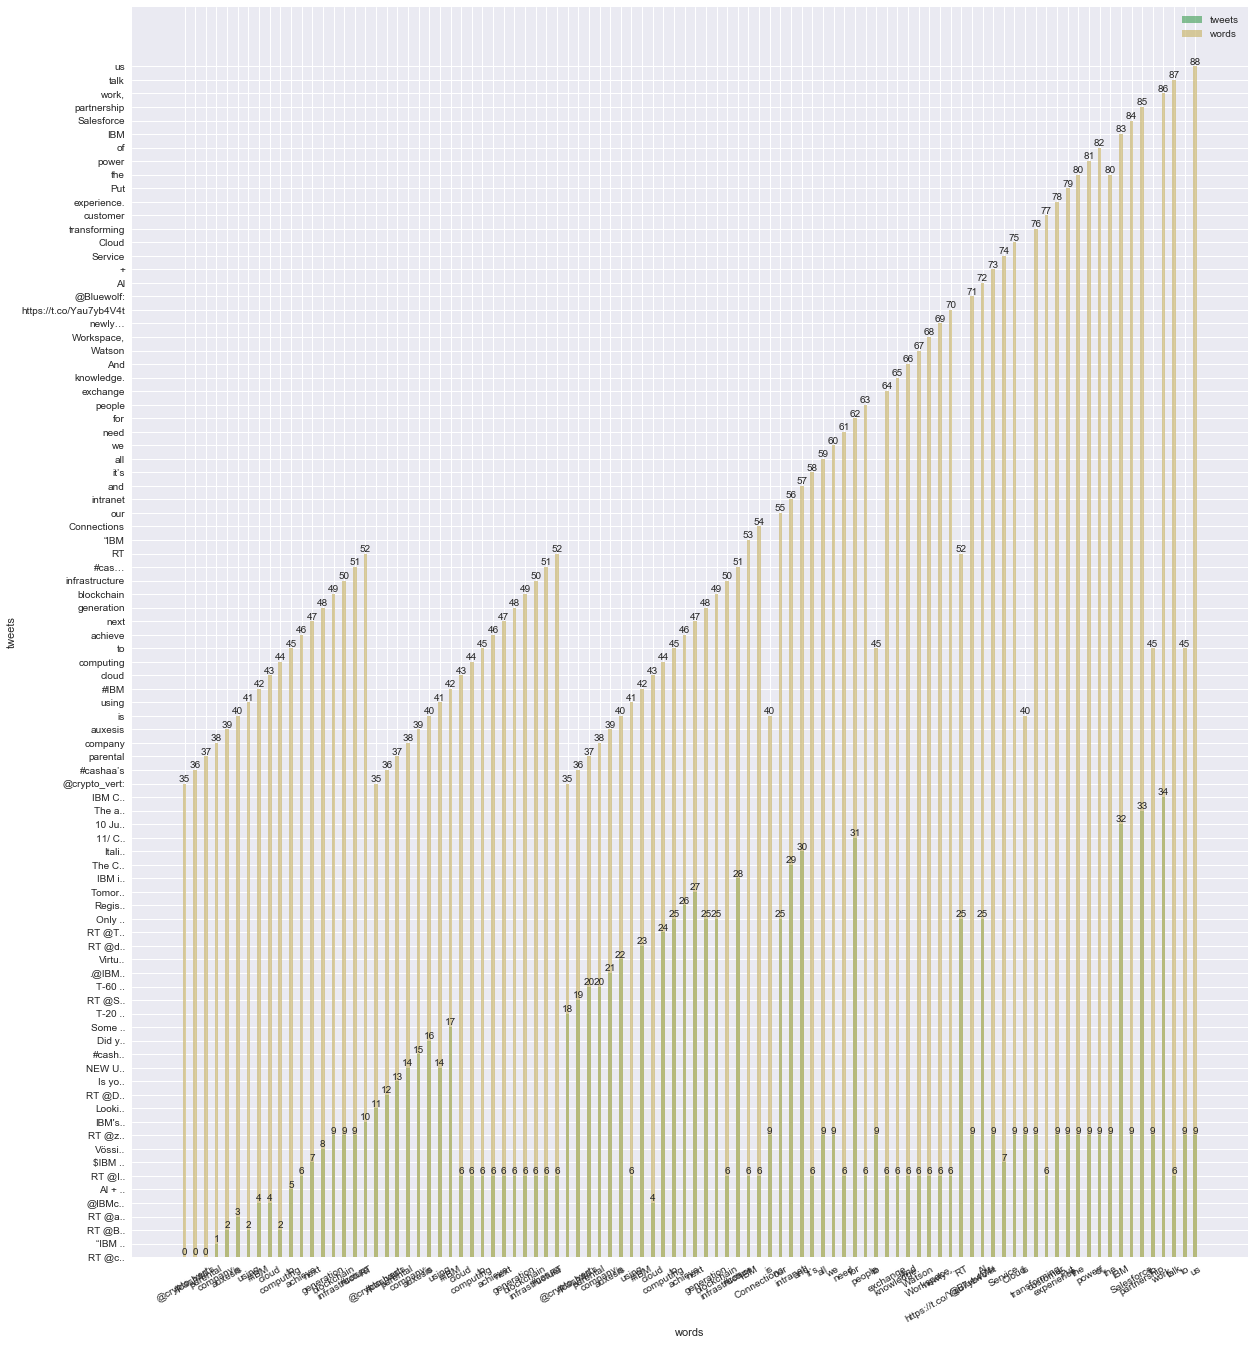

In [170]:
opacity = 0.7
bar_width = 0.35

plt.figure(figsize=(20,23))
plt.xlabel('words')
plt.ylabel('tweets')

plt.xticks(range(len(tweets)),words[1:len(tweets)+1], rotation=30)

bar1 = plt.bar(np.arange(len(tweets)), [(tweets[i][:5] + '..') for i in range(len(tweets)) if len(tweets) >= 5], bar_width, align='center', color='g', alpha=opacity, label='tweets')
bar2 = plt.bar(range(len(words[1:len(tweets)+1])), words[1:len(tweets)+1], bar_width, align='center', alpha=opacity, color='y', label='words')

for rect in bar1 + bar2:
    height = rect.get_height()
    #print height
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.legend()
plt.show()

<b>Examine Graph Properties</b>
- Identify neighbors of nodes in the network
- Get the number of nodes, and the number of edges
- Create visual of graph in networkx and matplotlib

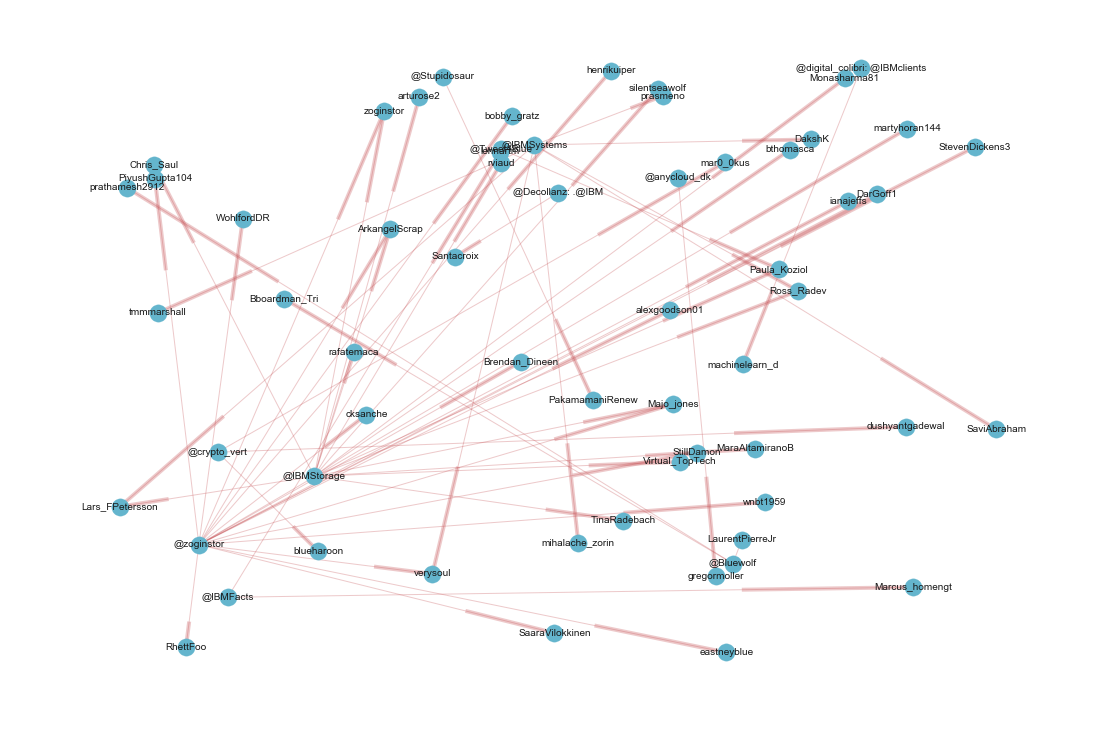

In [171]:
plt.figure(figsize=(19,13));
pos = nx.random_layout(g);
keys = pos.keys()
for key in keys:
    x, y = pos[key]
    pos_labels[key] = (x, y)
nx.draw_networkx_edges(g, pos, edge_color='r', alpha=.3);
nx.draw_networkx_nodes(g, pos, node_color='c', node_size=300);
nx.draw_networkx_labels(g, pos_labels, font_size=10) 
plt.axis('off')
plt.show()


In [172]:
print "The number of nodes are: ",g.number_of_nodes(),"\nThe number of edges: ",g.number_of_edges()

The number of nodes are:  61 
The number of edges:  57


- <b>Exercise a new tweet with `Top Cloud Companies` topic</b>

In [173]:
new_search_results = twitter_api.search.tweets(q="Top Cloud Companies", count=100)
new_statuses = new_search_results['statuses']

for _ in range(5): 
    try:
        next_results = new_search_results['search_metadata']['next_results']
    except KeyError, e: 
        break

    kwargs = dict([ kv.split('=') for kv in next_results[1:].split("&") ]) 
    new_search_results = twitter_api.search.tweets(**kwargs)
    new_statuses += new_search_results['statuses']
    
new_json_dumps = json.dumps(new_statuses[0:2], indent=1)

print new_json_dumps[:150]

[
 {
  "contributors": null, 
  "truncated": false, 
  "text": "RT @OracleIaaS: Infrastructure as a service is the second-most basic #cloud computing 


In [174]:
new_tweets = [new_status['text'] for new_status in new_statuses]
print new_tweets[0]

RT @OracleIaaS: Infrastructure as a service is the second-most basic #cloud computing model available to customers. Here are the top #IaaS…


<b>Area Under the Receiver Operating Characteristic curve (AUROC)</b>
- Let the vectorizer learn what tokens exist in the text data
- Turn these tokens into a numeric matrix
- Create a model
- tf-idf count text features exluding `English` stop words
- Use this model and our data to get 5-fold cross validation AUCs
- Print out the average AUC rounded to three decimal points

In [175]:
X_text = tweets
Y = new_tweets[:len(tweets)]

count_vectorizer = TfidfVectorizer(stop_words="english", lowercase=False)
count_vectorizer.fit(X_text)
X = count_vectorizer.transform(X_text)
logistic_regression = LogisticRegression()
aucs = cross_validation.cross_val_score(logistic_regression, X, Y, cv=5)
print "Area under the ROC curve for our classifier is " + str(np.mean(aucs))

Area under the ROC curve for our classifier is 0.298015873016


<b><u>Results Summary</u></b><br>
To conclude of what has been done throughout the project, we have made several call requests to the Twitter APIs in attempt to tweet about a subject, to read tweets about a topic (in our case, it was about `IBM Cloud Company`), to check the user's followers (count, relationship, names, etc.), visualized the outputs into graphs and plotted a matplotlib bar with counts, and also we extracted new tweets in regards a general topic about `Top Cloud Companies` then we applied a Naive Bayes logistic regression. The result for the Area under the ROC curve for our classifier came out weak.